In [1]:
from __future__ import division
import scipy.io
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance

from multiprocessing import Pool
np.set_printoptions(precision=2, suppress=True)

# Data Processing

In [19]:
d = scipy.io.loadmat('spamData.mat')
ytest = d['ytest'].flatten()
ytrain = d['ytrain'].flatten()
xtest = d['Xtest']
xtrain = d['Xtrain']

In [20]:
def binarize(array):
    """array: list of emails, each 57 features long"""
    return np.array([x>0 for x in array]).astype('uint8')
xtrainBin = binarize(xtrain)
xtestBin = binarize(xtest)

In [21]:
#z-normalise features
def znorm1D(array1D):
    m = np.mean(array1D)
    s = np.std(array1D)
    return np.array((array1D-m)/s)
def znorm2D(array2D):
    """znorm along columns of 2D array"""
    znormed_columns = np.array([znorm1D(c) for c in array2D.T]) # each column in array2D is a row (called c) in array2D.T
    return znormed_columns.T
xtrainZ = znorm2D(xtrain)
xtestZ = znorm2D(xtest)

In [22]:
#log-transform features
def log2D(array):
    """array: list of emails, each 57 features long"""
    return np.array([np.log(x+0.1) for x in array]) #x is a 57 element array
xtrainLog = log2D(xtrain)
xtestLog = log2D(xtest)

In [23]:
Kays = np.insert(np.arange(15,105,5),0,np.arange(1,11,1))
print Kays

[  1   2   3   4   5   6   7   8   9  10  15  20  25  30  35  40  45  50
  55  60  65  70  75  80  85  90  95 100]


# Binarised

In [6]:
def HammingDistance(email1,email2):
    """number of features that are different between two binarised lists"""
    return np.sum(np.logical_xor(email1,email2))

In [141]:
def HD(x1_array2D,x2_array2D): 
    """
    return Hamming Distances between mails x1 in x1_array2D and x2 in x2_array2D,
    not the most efficient...
    """
    return np.array([[HammingDistance(x1_array2D[idx1],x2_array2D[idx2]) for idx2 in np.arange(len(x2_array2D))] for idx1 in np.arange(len(x1_array2D))])

In [115]:
HD_train = HD(xtrainBin,xtrainBin) # compute all distances, go have some coffee...

In [124]:
# np.savetxt('HammingDistances_training.dat',np.array(HD_train))

In [142]:
HD_test = HD(xtestBin,xtrainBin) # compute all distances, go have some coffee...

In [143]:
# np.savetxt('HammingDistances_testing.dat',np.array(HD_test))

In [24]:
# HD_train = np.loadtxt('HammingDistances_training.dat')
# HD_test = np.loadtxt('HammingDistances_testing.dat')

In [135]:
HD_train[2]

array([25, 31,  0, ..., 13, 26, 33])

In [137]:
a = [0,1,2,3,4]
a[0:4]

[0, 1, 2, 3]

In [62]:
def KnnClassify_OneMail(distances_array1D, k,
                        y_array1D=ytrain):
    """
    classifies a single mail given a distance array specifying its distances from all other training mails
    as the distance array includes the distance from itself (0 units), 
    we find the k-nearest neighbours from the second smallest distance onwards.
    """
    ClosestEmails_Indices = np.argsort(distances_array1D)[0:k]
    Counts1 = np.sum(y_array1D[ClosestEmails_Indices]==1)
    Counts0 = np.sum(y_array1D[ClosestEmails_Indices]==0)
    return Counts1>Counts0

In [26]:
def KnnClassify_AllMails(distances_array2D,k):
    return np.array(
        [KnnClassify_OneMail(distances_array1D,k) for distances_array1D in distances_array2D]
    )

In [27]:
def error_rate(distances_array2D,y_array1D,k):
    """
    uses KNN to classify mails whose distance to the training mails is described by distances_array2D,
    y_array1D: class labels for comparison with classifier results
    """
    N = len(y_array1D)
    results = KnnClassify_AllMails(distances_array2D,k)
    return np.sum(np.logical_xor(results,y_array1D))/N*100

In [28]:
error_rate(HD_train,ytrain,1)

1.0766721044045677

In [63]:
Bin_ErrorRates_Testing = map(lambda k: error_rate(HD_test,ytest,k),Kays) 

In [91]:
# np.savetxt('Bin_ErrorRates_Testing.dat',Bin_ErrorRates_Testing)
# Bin_ErrorRates_Testing = np.loadtxt('Bin_ErrorRates_Testing.dat')

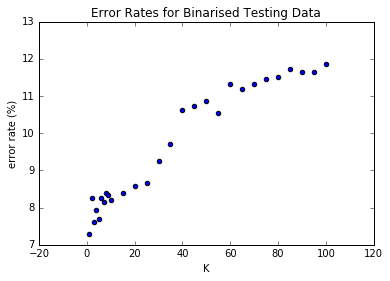

In [32]:
%matplotlib inline
plt.figure()
plt.title('Error Rates for Binarised Testing Data')
plt.scatter(Kays,Bin_ErrorRates_Testing)
plt.xlabel('K')
plt.ylabel('error rate (%)')
plt.show()

In [65]:
Bin_ErrorRates_Training = map(lambda k: error_rate(HD_train,ytrain,k),Kays) 

In [92]:
# np.savetxt('Bin_ErrorRates_Training.dat',Bin_ErrorRates_Training)
# Bin_ErrorRates_Training = np.loadtxt('Bin_ErrorRates_Training.dat')

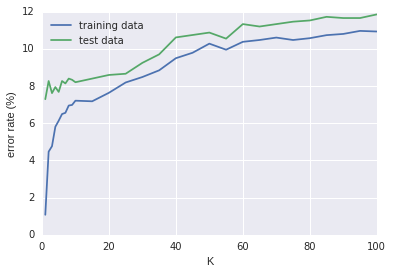

In [101]:
%matplotlib inline
import seaborn
plt.figure()
# plt.title('Error Rates for Binarised Training Data')
plt.plot(Kays,Bin_ErrorRates_Training, label='training data')
plt.plot(Kays,Bin_ErrorRates_Testing, label='test data')
plt.xlabel('K')
plt.ylabel('error rate (%)')
# plt.xlim(0,10)
plt.legend(loc='best')
plt.show()

In [93]:
# Error rates for K = 1,10,100
print np.array([np.array(Bin_ErrorRates_Training)[Kays==i] for i in [1,10,100]])
print np.array([np.array(Bin_ErrorRates_Testing)[Kays==i] for i in [1,10,100]])

[[  1.08]
 [  7.21]
 [ 10.93]]
[[  7.29]
 [  8.2 ]
 [ 11.85]]


In [221]:
# Define distance functions for continuous features

In [8]:
def EuclideanDistance(u,v):
    """uses scipy package to calculate euclidean distance"""
    return distance.euclidean(u,v)

In [9]:
def ED(x1_array2D,x2_array2D):
    """
    return Euclidean Distances between mails x1 in x1_array2D and x2 in x2_array2D,
    not the most efficient...
    """
    return np.array([[EuclideanDistance(x1_array2D[idx1],x2_array2D[idx2]) for idx2 in np.arange(len(x2_array2D))] for idx1 in np.arange(len(x1_array2D))])

# Z-normed

In [224]:
ED_TrainingZ = ED(xtrainZ,xtrainZ)

In [225]:
# np.savetxt('EuclideanDistances_TrainingZ.dat',np.array(ED_TrainingZ))

In [74]:
# ED_TrainingZ = np.loadtxt('EuclideanDistances_TrainingZ.dat')

In [226]:
ED_TestingZ = ED(xtestZ,xtrainZ)

In [227]:
# np.savetxt('EuclideanDistances_TestingZ.dat',np.array(ED_TestingZ))

In [75]:
# ED_TestingZ=np.loadtxt('EuclideanDistances_TestingZ.dat')

In [76]:
Z_ErrorRates_Testing = map(lambda k: error_rate(ED_TestingZ,ytest,k),Kays) 

In [77]:
Z_ErrorRates_Training = map(lambda k: error_rate(ED_TrainingZ,ytrain,k),Kays) 

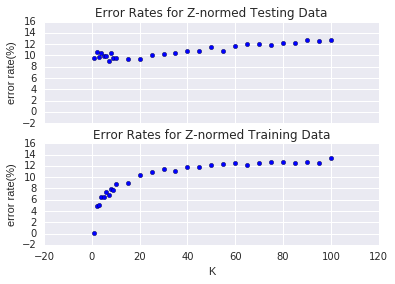

In [97]:
f, [ax0,ax1] = plt.subplots(2, sharex=True, sharey=True)
ax0.set_title('Error Rates for Z-normed Testing Data')
ax1.set_title('Error Rates for Z-normed Training Data')
ax0.scatter(Kays,Z_ErrorRates_Testing)
ax1.scatter(Kays,Z_ErrorRates_Training)
ax1.set_xlabel('K')
ax0.set_ylabel('error rate(%)')
ax1.set_ylabel('error rate(%)')

In [96]:
# Error rates for K = 1,10,100
print [np.array(Z_ErrorRates_Training)[Kays==i] for i in [1,10,100]]
print [np.array(Z_ErrorRates_Testing)[Kays==i] for i in [1,10,100]]

[array([ 0.07]), array([ 8.71]), array([ 13.31])]
[array([ 9.57]), array([ 9.51]), array([ 12.76])]


# Log-transformed

In [10]:
ED_TrainingLog = ED(xtrainLog,xtrainLog)

In [12]:
# np.savetxt('EuclideanDistances_TrainingLog.dat',np.array(ED_TrainingLog))

In [13]:
ED_TestingLog = ED(xtestLog,xtrainLog)

In [14]:
# np.savetxt('EuclideanDistances_TestingLog.dat',np.array(ED_TestingLog))

In [15]:
Log_ErrorRates_Testing = map(lambda k: error_rate(ED_TestingLog,ytest,k),Kays) 

In [71]:
Log_ErrorRates_Training = map(lambda k: error_rate(ED_TrainingLog,ytrain,k),Kays) 

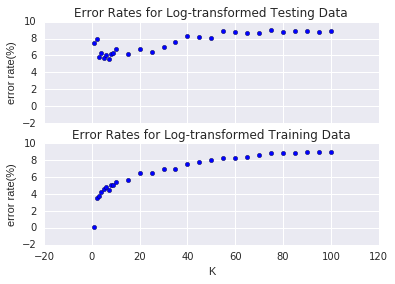

In [98]:
g, [ax0,ax1] = plt.subplots(2, sharex=True, sharey=True)
ax0.set_title('Error Rates for Log-transformed Testing Data')
ax1.set_title('Error Rates for Log-transformed Training Data')
ax0.scatter(Kays,Log_ErrorRates_Testing)
ax1.scatter(Kays,Log_ErrorRates_Training)
ax1.set_xlabel('K')
ax0.set_ylabel('error rate(%)')
ax1.set_ylabel('error rate(%)')

In [99]:
# Error rates for K = 1,10,100
print [np.array(Log_ErrorRates_Training)[Kays==i] for i in [1,10,100]]
print [np.array(Log_ErrorRates_Testing)[Kays==i] for i in [1,10,100]]

[array([ 0.07]), array([ 5.48]), array([ 8.97])]
[array([ 7.49]), array([ 6.77]), array([ 8.85])]


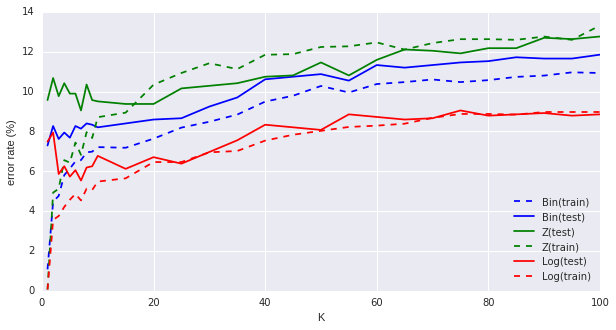

In [100]:
plt.figure(figsize=(10,5))
plt.plot(Kays,Bin_ErrorRates_Training, ls = '--', color='b', label='Bin(train)')
plt.plot(Kays,Bin_ErrorRates_Testing, color='b', label='Bin(test)')

plt.plot(Kays,Z_ErrorRates_Testing, color='g', label='Z(test)')
plt.plot(Kays,Z_ErrorRates_Training, ls = '--', color='g', label='Z(train)')

plt.plot(Kays,Log_ErrorRates_Testing, color='r', label='Log(test)')
plt.plot(Kays,Log_ErrorRates_Training, ls = '--', color='r', label='Log(train)')

plt.xlabel('K')
plt.ylabel('error rate (%)')
# plt.xlim(1,5)
# plt.semilogx()
plt.legend(loc='best')
plt.show()